# Finding shape parameters with pyssam

This example visualises how pyssam can be used to parameterise a dataset of shapes, using the `fit_model_parameters`. The output of this function can be thought of as a latent variable, which quantifies how strongly each mode of the trained SSM acts on a particular input shape. 

We will show this on seen and unseen (new) shapes, and examine shape model parameters against "physical" properties (in this case, torus radius).


In [38]:
import pyssam

In [39]:
from copy import copy
import matplotlib.pyplot as plt
import numpy as np
import vedo as v

First, we source landmark data to use in our shape model

In [40]:
N_SAMPLES = 50
torus = pyssam.datasets.Torus()
torus_data = torus.make_dataset(N_SAMPLES)
landmark_coordinates = np.array([torus_i.points() for torus_i in torus_data])

And also some testing data

In [41]:
torus_test = pyssam.datasets.Torus()
torus_data_test = torus_test.make_dataset(N_SAMPLES_TEST)
landmark_coordinates_unseen = np.array([torus_i.points() for torus_i in torus_data_test])

## Initialising the model

Here we convert to landmark coordinates into a parameterised shape model. We first initialise the class, which handles all pre-processing. Then, we can compute the shape model components and mean population shape

In [42]:
# if USE_SCALED_DATA = True, we should have 1 mode. If False, we should have 2 modes.
USE_SCALED_DATA = False

ssm_obj = pyssam.SSM(landmark_coordinates)
if USE_SCALED_DATA:
    ssm_obj.create_pca_model(ssm_obj.landmarks_columns_scale)
else:
    ssm_obj.create_pca_model(landmark_coordinates.reshape(N_SAMPLES, -1))
mean_shape_columnvector = ssm_obj.compute_dataset_mean()
mean_shape = mean_shape_columnvector.reshape(-1, 3)
shape_model_components = ssm_obj.pca_model_components

/Users/josh.williams/miniconda3/envs/pyssam/lib/python3.10/site-packages/pyssam/statistical_model_base.py:331: UserWarning: Dataset mean should be 0, is equal to [0.00694489 0.00603186 0.00644311 0.00688802 0.0072719  0.00662281
 0.00630028 0.006289   0.00609813 0.00656859 0.00549275 0.00637688
 0.00667762 0.00645718 0.00660851 0.00736836 0.00682943 0.00622861
 0.00582713 0.00647657 0.00699267 0.00610517 0.00599784 0.00605256
 0.00679629 0.00576377 0.00649954 0.00641731 0.00581839 0.0061306
 0.00660275 0.00645817 0.00674524 0.00633049 0.00622639 0.00662017
 0.00564614 0.00646752 0.0060277  0.00646826 0.00703665 0.00640417
 0.00736323 0.00617604 0.0063535  0.0060149  0.00598371 0.00627023
 0.00638004 0.0063343 ]
  warn("Dataset mean should be 0, " f"is equal to {dataset.mean(axis=1)}")
/Users/josh.williams/miniconda3/envs/pyssam/lib/python3.10/site-packages/pyssam/statistical_model_base.py:336: UserWarning: Dataset standard deviation should be 1, is equal to [1.5292362 1.2406789 1.31111

## Plotting and analysis

In [43]:
# Define some plotting functions

def plot_cumulative_variance(explained_variance, target_variance=-1):
    number_of_components = np.arange(0, len(explained_variance))+1
    fig, ax = plt.subplots(1,1)
    color = "blue"
    ax.plot(number_of_components, explained_variance*100.0, marker="o", ms=2, color=color, mec=color, mfc=color)
    if target_variance > 0.0:
        ax.axhline(target_variance*100.0)
    
    ax.set_ylabel("Variance [%]")
    ax.set_xlabel("Number of components")
    ax.grid(axis="x")
    plt.show()
    
def plot_shape_modes(
  mean_shape_columnvector, 
  mean_shape, 
  original_shape_parameter_vector,
  shape_model_components,
  mode_to_plot,
):
  weights = [-2, 0, 2]
  fig, ax = plt.subplots(1, 3, figsize=(10, 4))
  x_min, x_max, y_min, y_max = np.inf, -np.inf, np.inf, -np.inf
  mode_outputs = []
  for j, weights_i in enumerate(weights):
    shape_parameter_vector = copy(original_shape_parameter_vector)
    shape_parameter_vector[mode_to_plot] = weights_i
    mode_i_coords = ssm_obj.morph_model(
        mean_shape_columnvector, 
        shape_model_components, 
        shape_parameter_vector
    ).reshape(-1, 3)
    print(mode_i_coords.min(axis=0), mode_i_coords.max(axis=0))

    offset_dist = pyssam.utils.euclidean_distance(
      mean_shape, 
      mode_i_coords
    )
    # colour points blue if closer to point cloud centre than mean shape
    mean_shape_dist_from_centre = pyssam.utils.euclidean_distance(
      mean_shape,
      np.zeros(3),
    )
    mode_i_dist_from_centre = pyssam.utils.euclidean_distance(
      mode_i_coords,
      np.zeros(3),
    )
    offset_dist = np.where(
        mode_i_dist_from_centre<mean_shape_dist_from_centre,
        offset_dist*-1,
        offset_dist,
    )
    if weights_i == 0:
      ax[j].scatter(
        mode_i_coords[:, 0],
        mode_i_coords[:, 1],
        c="gray",
        s=1,
      )
      ax[j].set_title("mean shape")
    else:
      ax[j].scatter(
        mode_i_coords[:, 0],
        mode_i_coords[:, 1],
        c=offset_dist,
        cmap="seismic",
        vmin=-1,
        vmax=1,
        s=1,
      )
      ax[j].set_title(f"mode {mode_to_plot} \nweight {weights_i}")
    mode_outputs.append(mode_i_coords)
    if mode_i_coords[:,0].min() < x_min:
        x_min = mode_i_coords[:,0].min()
    if mode_i_coords[:,1].min() < y_min:
        y_min = mode_i_coords[:,1].min()
    if mode_i_coords[:,0].max() > x_max:
        x_max = mode_i_coords[:,0].max()
    if mode_i_coords[:,1].max() > y_max:
        y_max = mode_i_coords[:,1].max()
    ax[j].axis('off')
    ax[j].margins(0,0)
    ax[j].xaxis.set_major_locator(plt.NullLocator())
    ax[j].yaxis.set_major_locator(plt.NullLocator())

  for j, weights_i in enumerate(weights):
    ax[j].set_xlim([x_min, x_max])
    ax[j].set_ylim([y_min, y_max])
  plt.show()
  return mode_outputs

To check how different the shapes we are dealing with are, we first visualise the modes as point cloud from pyssam.

explained variance is 0.8452807664871216
[-1.67783673 -1.69173058 -0.09752887] [1.67783673 1.663588   0.09752887]
[-2.26314473 -2.27684951 -0.72365183] [2.26314473 2.24895287 0.72365183]
[-2.84845273 -2.86196843 -1.34977479] [2.84845273 2.834324   1.34977479]


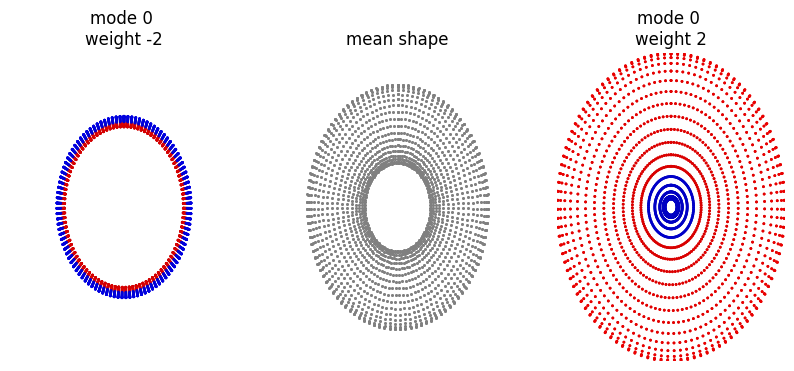

In [44]:
mode_to_plot = 0
print(f"explained variance is {ssm_obj.pca_object.explained_variance_ratio_[mode_to_plot]}")

mode_outputs = plot_shape_modes(
    mean_shape_columnvector, 
    mean_shape, 
    ssm_obj.model_parameters,
    ssm_obj.pca_model_components,
    mode_to_plot,
)

If the variable `USE_SCALED_DATA` above is true, the following should show essentially no variation.

explained variance is 0.15471918880939484
[-1.98515838 -1.99895312 -0.71340161] [1.98515838 1.9709423  0.71340161]
[-2.26314473 -2.27684951 -0.72365183] [2.26314473 2.24895287 0.72365183]
[-2.54113109 -2.55474589 -0.73390204] [2.54113109 2.5269691  0.73390204]


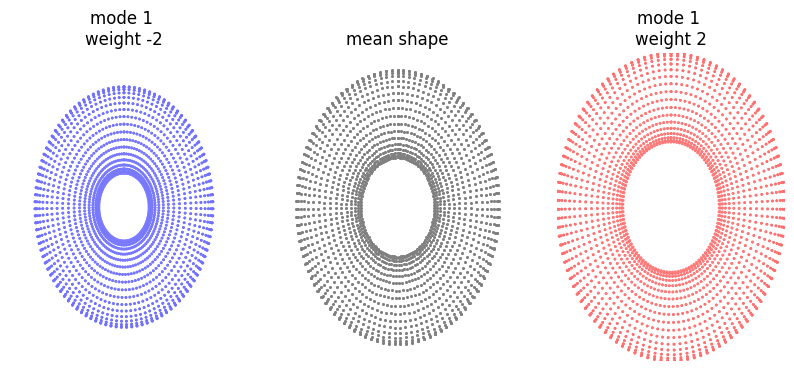

[array([[ 8.89302411e-06,  1.97094230e+00, -1.23352517e-09],
        [ 2.93854377e-09,  1.95946024e+00,  1.27511177e-01],
        [ 2.91359055e-09,  1.92540043e+00,  2.50924059e-01],
        ...,
        [ 2.88154240e-09,  1.92540043e+00, -2.50924059e-01],
        [ 2.88154219e-09,  1.95946024e+00, -1.27511177e-01],
        [ 2.88154219e-09,  1.97093663e+00,  1.03446948e-10]]),
 array([[ 2.88157453e-09,  2.24895287e+00,  1.03447167e-10],
        [ 2.88157453e-09,  2.23731160e+00,  1.29343271e-01],
        [ 2.88157453e-09,  2.20276237e+00,  2.54529357e-01],
        ...,
        [ 2.88153790e-09,  2.20276237e+00, -2.54529357e-01],
        [ 2.88153768e-09,  2.23731160e+00, -1.29343271e-01],
        [ 2.88153768e-09,  2.24895287e+00,  1.03446945e-10]]),
 array([[-8.88726096e-06,  2.52696343e+00,  1.44041950e-09],
        [ 2.82460530e-09,  2.51516297e+00,  1.31175366e-01],
        [ 2.84955852e-09,  2.48012430e+00,  2.58134655e-01],
        ...,
        [ 2.88153340e-09,  2.48012430e+00,

In [45]:
mode_to_plot = 1
print(f"explained variance is {ssm_obj.pca_object.explained_variance_ratio_[mode_to_plot]}")

plot_shape_modes(
    mean_shape_columnvector, 
    mean_shape, 
    ssm_obj.model_parameters,
    ssm_obj.pca_model_components,
    mode_to_plot,
)

The above plots are useful, but it is nicer to visualise the output as a surface.

## Shape analysis

First, lets study the shape parameters for the training data. We will use `fit_model_parameters()` to compute the shape coefficients for each mode.

In [46]:
ssm_params_train = np.array([
  ssm_obj.fit_model_parameters(x.reshape(-1), ssm_obj.pca_model_components, num_modes=2) 
  for x in landmark_coordinates
])

Plotting these shows mode 1 is strongly correlated with the inner radius, and mode 2 is correlated with the outer radius.

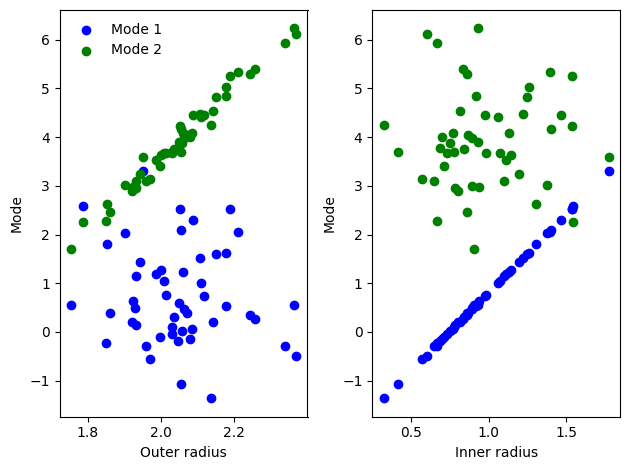

In [47]:
fig, ax = plt.subplots(1, 2)
ax[0].scatter(torus.outer_radius_arr, ssm_params_train[:,0], label="Mode 1", c="blue")
ax[0].scatter(torus.outer_radius_arr, ssm_params_train[:,1], label="Mode 2", c="green")
ax[1].scatter(torus.inner_radius_arr, ssm_params_train[:,0], label="Mode 1", c="blue")
ax[1].scatter(torus.inner_radius_arr, ssm_params_train[:,1], label="Mode 2", c="green")
ax[0].set_xlabel("Outer radius")
ax[1].set_xlabel("Inner radius")
ax[0].set_ylabel("Mode")
ax[1].set_ylabel("Mode")
ax[0].legend(frameon=False)
fig.tight_layout()
plt.show()

We then use `fit_model_parameters` with unseen input data

In [48]:
ssm_params_test = np.array([
  ssm_obj.fit_model_parameters(x.reshape(-1), ssm_obj.pca_model_components, num_modes=2) 
  for x in landmark_coordinates_unseen
])

As the unseen data is constructed from a toy dataset with the same parameters as the training dataset, we get strong correlation. This approach can be used to compare how a shape parameter changes with in more complex populations such as diseased vs non-diseased organs.

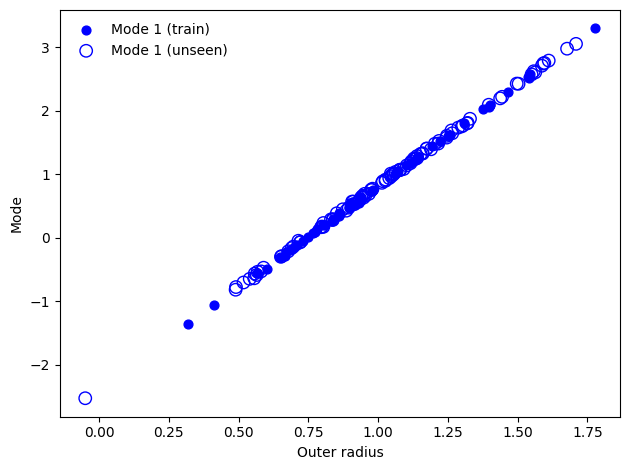

In [49]:
fig, ax = plt.subplots(1, 1)
ax.scatter(torus.inner_radius_arr, ssm_params_train[:,0], label="Mode 1 (train)", s=40, c="blue")
ax.scatter(torus_test.inner_radius_arr, ssm_params_test[:,0], facecolors='none', s=80, edgecolors="blue", label="Mode 1 (unseen)")
ax.set_xlabel("Outer radius")
ax.set_ylabel("Mode")
ax.legend(frameon=False)
fig.tight_layout()
plt.show()